# 5.2 합성곱 신경망 맛보기

: fashion_mnist 데이터셋을 사용해 합성곱 신경망 구현하기

**[fashion_mnist 데이터셋]**
torchvision에 내장된 예제 데이터로 운도오하, 셔츠, 샌들 같은 작은 이미지모음
기본 MNIST 데이터셋처럼 열 가지로 분류될 수 잇는 28*28 픽셀 이미지 7만 개로 구성


*   훈련 데이터(train_images): 0-255 사이의 값을 갖는 28*28 크기의 넘파이 배열
*   정답 데이터(train_labels): 0-9까지의 정수 값을 갖는 배열

0에서 9까지의 정수 값은 이미지의 클래스(운동화, 셔츠 등)를 나타내는 레이블임




In [4]:
# 라이브러리 호출
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms # 데이터 전처리를 위해 사용하는 라이브러리
from torch.utils.data import Dataset, DataLoader

In [6]:
# CPU 혹은 GPU 장치 확인
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
#fashoin_mnist dataset 내려받기
train_dataset  = torchvision.datasets.FashionMNIST("FashionMNIST/", download=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))
test_dataset  = torchvision.datasets.FashionMNIST("FashionMNIST/", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()]))

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.8MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 171kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.13MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 14.8MB/s]


torchvizion.datasets는 torch.utils.data.Dataset의 하위 클래스로 다양한 데이터셋(CIFAR, COCO, MNIST, ImageNet 등)을 포함함

In [8]:
# fashion_minist 데이터를 데이터로더에 전달
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100)

torch.utils.data.DataLoader()를 사용해 원하는 크기의 배치단위로 데이터를 불러오거나 무작위로 섞이도록(shuffle)할 수 있음

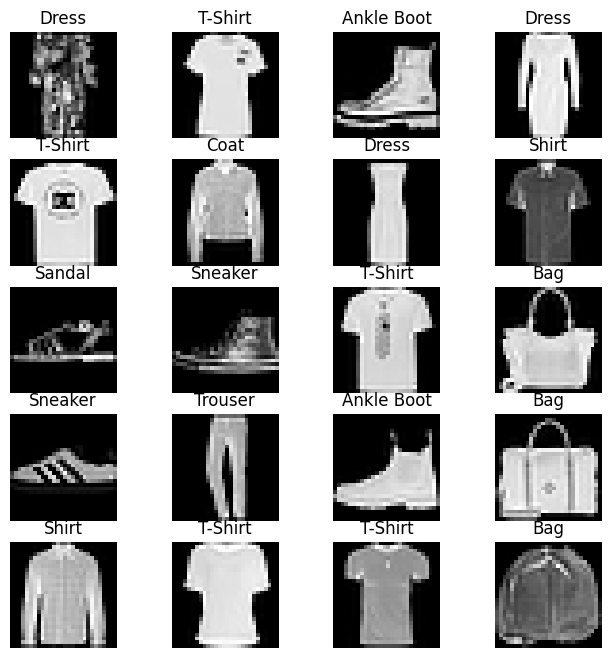

In [9]:
# 분류에 사용될 클래스 정의
labels_map = {0: 'T-Shirt', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat',
              5: 'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle Boot'}
fig = plt.figure(figsize=(8,8)) # 출력할 이미지의 가로세로 길이 inch
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(train_dataset))
    img = train_dataset[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show() # 20개의 이미지를 무작위로 표현

In [23]:
# 심층 신경망 모델 생성
class FashionDNN(nn.Module):
    def __init__(self):
        super(FashionDNN, self).__init__()
        self.fc1 = nn.Linear(in_features=784, out_features=256)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)

    def forward(self, input_data):
        out = input_data.view(-1,784)
        out = F.relu(self.fc1(out))
        out = self.drop(out)
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out




*   torch.nn.Dropout(p) : p만큼의 비율로 텐서의 값이 0이 되고, 0이 되지 않은 값들은 기존 값에 (1/(1-p))만큼 곱해져 커짐

*   활성화함수를 지정할 때는 두 가지 방법이 가능
    - F.relu(): forward() 함수에서 정의
    - nn.ReLU(): __ init __() 함수에서 정의



In [24]:
# 심층 신경망에서 필요한 파라미터 정의
learning_rate = 0.001
model = FashionDNN()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [25]:
# 심층 신경망을 이용한 모델 학습
num_epochs = 5
count = 0
loss_list=[]
iteration_list=[]
accuracy_list=[]

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        train = Variable(images.view(100,1,28,28))
        labels = Variable(labels)

        outputs = model(train) # 학습 데이터를 모델에 적용
        loss =  criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1

        if not (count % 50):
            total = 0
            correct=0
            for images, labels in test_loader:
                images, labels =images.to(device), labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100,1,28,28))
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)

            accuracy = correct * 100/total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if not (count % 500):
            print("Iteration: {}, Loss:{} Accuracy: {}%".format(count, loss.data, accuracy))


Iteration: 500, Loss:0.6321585178375244 Accuracy: 82.79000091552734%
Iteration: 1000, Loss:0.5468452572822571 Accuracy: 84.11000061035156%
Iteration: 1500, Loss:0.36845633387565613 Accuracy: 84.68000030517578%
Iteration: 2000, Loss:0.4037477970123291 Accuracy: 85.79999542236328%
Iteration: 2500, Loss:0.25255286693573 Accuracy: 86.29000091552734%
Iteration: 3000, Loss:0.31004559993743896 Accuracy: 86.08999633789062%


In [19]:
# 합성곱 네트워크 생성
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out


 nn.Sequential : init()에서 사용할 네트워크 모델들을 정의해주고, forward()함수에서 구현될 순전파를 layer 형태로 가독성있게 코드를 작성할 수 있음


> nn.Sequetial은 계층을 차례대로 쌓을 수 있도록 Wx+b와 같은 수식과 활성화함수를 연결해 주는 역할을 함

합성곱층은 합성곱 연산을 통해서 이미지 특징을 추출
커널(n*m 크기의 행렬)이 이미지(h*w)를 훑으며 각 원소값끼리 곱한 후 더한 값을 출력
Conv2d [입력이 이미지 데이터]
* in_channels : 입력 채널의 수 ( 흑백 이미지는 1, RGB는 3인 경우가 많음)
* out_channels : 출력 채널의 수
* kernel_size: 3이라고 했을 때 (3,3)의미
* padding: 출력 크기를 조절하기 위해 입력 데이터 주위에 0을 채우는 크기, 출력값과 비례

BatchNorm2d: 학습 과정에서 각 배치 단위별로 데이터가 다양한 분포를 가지더라도 평균과 분산을 이용하여 정규화하는 것

MaxPool2d: 이미지 크기를 축소시키는 용도(풀링) [입력이 이미지 데이터]

kernel_size: m*n 행렬로 구성된 가중치
stride: 출력값과 반비례

in_features: 입력 데이터의 크기
out_features: 출력 데이터의 크기




In [20]:
# 합성곱 네트워크를 위한 파라미터 정의
learning_rate = 0.001
model = FashionCNN()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [21]:
num_epochs = 5
count = 0
loss_list=[]
iteration_list=[]
accuracy_list=[]

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        train = Variable(images.view(100,1,28,28))
        labels = Variable(labels)

        outputs = model(train)
        loss =  criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1

        if not (count % 50):
            total = 0
            correct=0
            for images, labels in test_loader:
                images, labels =images.to(device), labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100,1,28,28))
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)

            accuracy = correct * 100/total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if not (count % 500):
            print("Iteration: {}, Loss:{} Accuracy: {}%".format(count, loss.data, accuracy))


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Iteration: 500, Loss:0.46127253770828247 Accuracy: 88.08999633789062%
Iteration: 1000, Loss:0.2912640869617462 Accuracy: 88.22999572753906%
Iteration: 1500, Loss:0.3206319510936737 Accuracy: 88.98999786376953%
Iteration: 2000, Loss:0.2145872861146927 Accuracy: 89.19999694824219%
Iteration: 2500, Loss:0.13563239574432373 Accuracy: 89.5999984741211%
Iteration: 3000, Loss:0.1481342911720276 Accuracy: 90.38999938964844%
